# <div align="center"><b> APSERa Final - Getting and Saving residuals </b></div>


In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import math
import ephem
from scipy.signal import correlate

from scipy.optimize import curve_fit

%matplotlib inline
from scipy.signal import savgol_filter
from pygsm import GlobalSkyModel
from ms_fit_joint_inf import ms_fit_inf, chisq_poly
import maxsmooth
from maxsmooth.DCF import smooth

from astropy.timeseries import TimeSeries, BinnedTimeSeries
from astropy.time import Time, TimeDelta
from astropy.coordinates import Galactic, SkyCoord, FK5, EarthLocation, AltAz, Angle
import astropy.units as u

import pandas as pd
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline, RegularGridInterpolator



In [4]:
start_time_in_UTC = '2024-05-19 20:00:00'
n_spectra = 1                 #Number of spectra to be taken
delta_t_in_hours = 1            #Time interval between each spectra needed in hours

t = Time(start_time_in_UTC, format = 'iso', scale= 'utc')

ts = TimeSeries(time_start= start_time_in_UTC, time_delta= delta_t_in_hours *u.hour, n_samples= n_spectra)
ts = ts.time
print(ts)

['2024-05-19 20:00:00.000']


In [5]:
h = 6.62607157e-34
k = 1.3806488e-23
c = 2.99792458e+08
TCMB = 2.72548
f_start = 2.0
f_stop = 4.0
No_of_Channels = 201
Channel_width = 0.01
N_SIDE = 16
T_hot = 3730
T_cold = 2730                    #T_cold and T_hot in Kelvins
Time_in_UTC = ts
latitude = 12.9716
longitude = 77.5946            #Latitude and longitude in degrees
altitude = 920                     #Altitude in meters
alpha = 0.0065                   #Temp. lapse rate (deg C per meter)
PI = 3.14159265
Noise_int_time = 3e+12
Trx = 14
T_atm = 1
freqs = np.linspace(f_start,f_stop, No_of_Channels)
CMB_Int = np.empty([No_of_Channels])
P_hot = np.empty(No_of_Channels)
P_cold = np.empty(No_of_Channels)
P_dif = np.empty(No_of_Channels)
cross_real_with_sig = [0]*No_of_Channels
cross_real_no_sig = [0]*No_of_Channels
cross_imag_with_sig = [0]*No_of_Channels
cross_imag_no_sig = [0]*No_of_Channels
final_temp_with_sig = [0]*No_of_Channels
final_temp_no_sig = [0]*No_of_Channels
sumwt_with_sig = [0]*No_of_Channels
sumwt_no_sig = [0]*No_of_Channels
sigma = [0]*No_of_Channels
spectra_with_sig = [0]*n_spectra
spectra_no_sig = [0]*n_spectra
NPIX = hp.nside2npix(N_SIDE)


#Refraction correction formula
def refraction(alt_in_deg, altitude):
    pres = 1010.*math.pow((1-6.5/288000*altitude),5.255)
    if (altitude>11000):
        temp = 211.5
    else:
        temp = 283.0 - (alpha * altitude)
    R = 1.02/math.tan((alt_in_deg + (10.3/(alt_in_deg + 5.11)))*(PI/180))
    if (alt_in_deg == 90):
        R = R+ 0.0019279
    tpcor = (pres/1000) * (283/temp)
    R =  tpcor*(R/60)
    return alt_in_deg +R



Obs = ephem.Observer()
t = Time(Time_in_UTC, scale='utc',location= EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m))
lst = t.sidereal_time('apparent')
print(lst)

[17h02m17.32850041s]


## <div align="center"><b> Getting maps, calculating CMB intensity </b></div>


In [6]:
gsm = GlobalSkyModel(freq_unit='GHz')

CMB_Int = ((2*h*1e+27*freqs**3)/(c*c))/(np.exp((h*freqs*1e+9)/(k*TCMB))-1)
print("Got CMB Int!")

#P_hot and P_cold for calibration
P_hot = (2*h*freqs*1e9)/(np.exp((h*freqs*1e9)/(k*T_hot))-1)
P_cold = (2*h*freqs*1e9)/(np.exp((h*freqs*1e9)/(k*T_cold))-1)
P_dif = P_hot -P_cold

print("Got P_dif for calibration!")

sky_1420 = hp.ud_grade(np.loadtxt('1420MHz_Sky_map.txt') - TCMB, 16, order_in = "NESTED", order_out= "RING")

sky_408 = hp.ud_grade(((np.loadtxt('408MHz_Sky_map.txt'))/1000) - TCMB, 16, order_in = "NESTED", order_out= "RING")

sky_23000 = hp.ud_grade((np.loadtxt('23000MHz_Sky_map.txt')/1000), 16, order_in = "NESTED", order_out= "RING")

print("Got 408MHz, 1420MHz and 23000MHz maps for power law fitting!")

Got CMB Int!
Got P_dif for calibration!
Got 408MHz, 1420MHz and 23000MHz maps for power law fitting!


## <div align="center"><b> Getting recombination lines </b></div>


/tmp/ipykernel_61843/115827261.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(r'total_spec_new.txt',sep= "    " ,header = None)


<IPython.core.display.Javascript object>


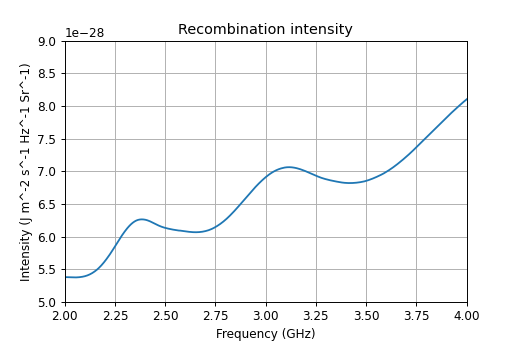

In [7]:
%matplotlib notebook
#/home/dhashin/workspace/APSERa/

df = pd.read_csv(r'total_spec_new.txt',sep= "    " ,header = None)
df.reset_index(drop=True, inplace=True)
df.columns = ["Frequency","Intensity"]

x = df["Frequency"]
y= df["Intensity"]

plt.plot((df['Frequency']), (df['Intensity']))
plt.title('Recombination intensity')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Intensity (J m^-2 s^-1 Hz^-1 Sr^-1)')
plt.xlim([f_start,f_stop])
plt.ylim([0.5e-27,0.9e-27])
plt.grid()
plt.show()

ius = InterpolatedUnivariateSpline(x, y)
Rec_int = ius(freqs)



Working for 1d stretch: 0.0 ...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


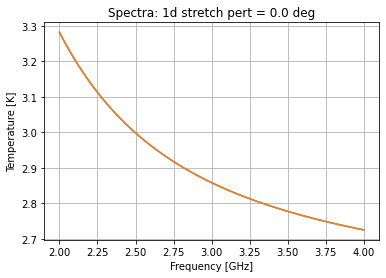

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201


/tmp/ipykernel_61843/3998823591.py:466: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq1, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq1 =  9.225609578099543e-06
2.725949419612931 -0.2191498649062068 -2.6778447538391483
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 267
         Function evaluations: 545
 
chisq2 =  7.905254910717796e-09
2.725479815450805 -0.2187902247803708 -2.676850728974662 0.015597857986380382
 


/tmp/ipykernel_61843/3998823591.py:486: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq3, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq3 =  7.607177041583643e-09
2.7254807584296126 -0.21879089697198853 -2.6768553647756006 0.015592569756670801 -6.411206048874128e-05
 


/tmp/ipykernel_61843/3998823591.py:496: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq4, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq4 =  7.607176779486722e-09
2.7254807584297462 -0.2187908969720842 -2.676855364776263 0.01559256975599807 -6.411206974616393e-05 -2.1501181034078648e-15
 


/tmp/ipykernel_61843/3998823591.py:506: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq5, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq5 =  7.607176779012272e-09
2.7254807584297462 -0.2187908969720842 -2.676855364776263 0.015592569755997857 -6.411206974529545e-05 -2.150118154685253e-15 -1.7444109690055472e-21
 


/tmp/ipykernel_61843/3998823591.py:516: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq6, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq6 =  7.607176779012272e-09
2.7254807584297462 -0.2187908969720842 -2.676855364776263 0.015592569755997857 -6.411206974529545e-05 -2.150118154685253e-15 -1.7444109690055472e-21 0.0
 


/tmp/ipykernel_61843/3998823591.py:526: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq7, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq7 =  7.607176748392835e-09
2.7254807584297462 -0.2187908969720842 -2.676855364776263 0.015592569755997857 -6.411226532666164e-05 -2.150118154685253e-15 -1.7444109690055472e-21 0.0 0.0
 


/tmp/ipykernel_61843/3998823591.py:536: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq8, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq8 =  7.607176748392835e-09
2.7254807584297462 -0.2187908969720842 -2.676855364776263 0.015592569755997857 -6.411226532666164e-05 -2.150118154685253e-15 -1.7444109690055472e-21 0.0 0.0 0.0


/tmp/ipykernel_61843/3998823591.py:543: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq9, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq9 =  7.607176748392835e-09
2.7254807584297462 -0.2187908969720842 -2.676855364776263 0.015592569755997857 -6.411226532666164e-05 -2.150118154685253e-15 -1.7444109690055472e-21 0.0 0.0 0.0 0.0


/tmp/ipykernel_61843/3998823591.py:550: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq10, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq10 =  7.607176748392835e-09
2.7254807584297462 -0.2187908969720842 -2.676855364776263 0.015592569755997857 -6.411226532666164e-05 -2.150118154685253e-15 -1.7444109690055472e-21 0.0 0.0 0.0 0.0 0.0
 
[]
Limits in index:  0 200
201
201
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 263
         Function evaluations: 520
 
chisq1 =  9.228037756680166e-06
2.7259493844540383 -0.21915015121782833 -2.6778456259664676
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 240
         Function evaluations: 508
 
chisq2 =  1.8464585196010666e-09
2.72547965622961 -0.21879041595019427 -2.6768513362448747 0.015601983503135682
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 304
         Function evaluations: 639
 
chisq3 =  1.385383807612472e-10
2.7254804634892453 -0.21879099139125902 -2.6768553050543886 0.015597458576134083 -5.489045326

/tmp/ipykernel_61843/3998823591.py:682: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq7, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq7 =  1.3853829726668865e-10
2.7254804634892453 -0.21879099139125904 -2.6768553050543886 0.015597458576223472 -5.4890489881881254e-05 4.480786985532744e-18 1.3553230785151068e-20 0.0 0.0
 


/tmp/ipykernel_61843/3998823591.py:692: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq8, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq8 =  1.3853829726668865e-10
2.7254804634892453 -0.21879099139125904 -2.6768553050543886 0.015597458576223472 -5.4890489881881254e-05 4.480786985532744e-18 1.3553230785151068e-20 0.0 0.0 0.0


/tmp/ipykernel_61843/3998823591.py:699: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq9, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq9 =  1.3853829726668865e-10
2.7254804634892453 -0.21879099139125904 -2.6768553050543886 0.015597458576223472 -5.4890489881881254e-05 4.480786985532744e-18 1.3553230785151068e-20 0.0 0.0 0.0 0.0


/tmp/ipykernel_61843/3998823591.py:706: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq10, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq10 =  1.3853829726668865e-10
2.7254804634892453 -0.21879099139125904 -2.6768553050543886 0.015597458576223472 -5.4890489881881254e-05 4.480786985532744e-18 1.3553230785151068e-20 0.0 0.0 0.0 0.0 0.0
 
[]


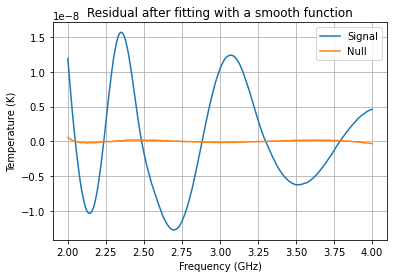

Working for 1d stretch: 0.03 ...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


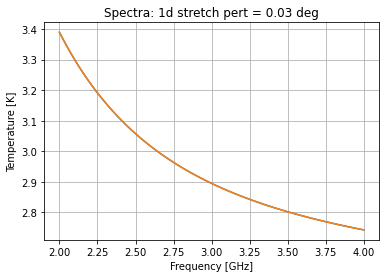

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  1.211526675473651e-05
2.7261871490439145 -0.1479607131210314 -2.684819669540617
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 264
         Function evaluations: 542
 
chisq2 =  1.3963848661868566e-07
2.7255747861219546 -0.14756248730957477 -2.683723170718209 0.017384228323743405
 
 
chisq3 =  9.763480814192018e-09
2.7255141049649496 -0.14752577817816356 -2.683469223650046 0.01767308603475138 0.003528474867223899
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 575
         Function evaluations: 1081
 
chisq4 =  7.425184386107173e-09
2.725484254480345 -0.14750755807248878 -2.6833585637680057 0.018067676773505167 0.0037942452425457473 0.002660333168997652
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 646
   

/tmp/ipykernel_61843/3998823591.py:642: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq3, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq3 =  7.42086975368479e-09
2.725513810990837 -0.14752585889250658 -2.6834691780995765 0.017677227195941753 0.003536343156241803
 


/tmp/ipykernel_61843/3998823591.py:652: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq4, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq4 =  1.7461317858761922e-10
2.725478872849552 -0.1475045334653373 -2.683339657759514 0.018139048609723596 0.0038475241484882215 0.003113248755374353
 


/tmp/ipykernel_61843/3998823591.py:662: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq5, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq5 =  1.7411276195605165e-10
2.7254788740773557 -0.14750453424504892 -2.683339658403876 0.018138923744228864 0.003848613695989496 0.0031085766311227734 6.584207760123838e-06
 


/tmp/ipykernel_61843/3998823591.py:672: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq6, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq6 =  1.7335467289452972e-10
2.725478850789284 -0.14750452001799605 -2.683339573403516 0.018139261106139268 0.0038486013991240304 0.0031110283096513784 8.16789559977791e-06 -4.519911306420664e-06
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 429
         Function evaluations: 991
 
chisq7 =  1.7334243858811732e-10
2.7254788507932695 -0.14750452002640357 -2.683339572968997 0.01813925378008628 0.003848641790800234 0.003110952205842914 8.183341311381467e-06 -4.519911306434334e-06 2.100244679892749e-13
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 134
         Function evaluations: 687
 
chisq8 =  1.733422602666849e-10
2.7254788507932695 -0.14750452002640357 -2.6833395729689977 0.01813925378008456 0.003848641790800197 0.0031109522058431153 8.184290307260293e-06 -4.519911306434337e-06 2.1002446798928578e-13 3.480006848208838e-18
Optimization terminated successfully.
      

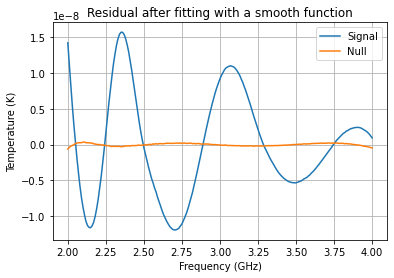

Working for 1d stretch: 0.06 ...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


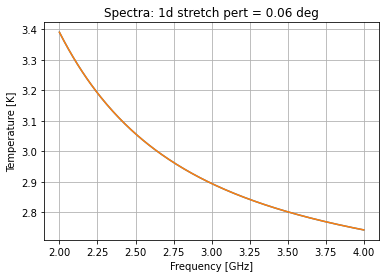

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  1.4591974156809606e-05
2.7263846248324906 -0.14737591641081269 -2.6901992044258067
 


/tmp/ipykernel_61843/3998823591.py:476: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq2, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq2 =  3.662290096976867e-07
2.7256506176992463 -0.14689912918535777 -2.688889147503135 0.020908826903486617
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 365
         Function evaluations: 733
 
chisq3 =  1.2371074339682128e-08
2.7254913283193853 -0.1468029215758898 -2.688222360742084 0.02166929422311773 0.009278584002653974
 
 
chisq4 =  7.748012122037173e-09
2.7254456130577482 -0.1467750647967585 -2.688052853109586 0.02227383021481131 0.009691632171817396 0.004064082038839823
 
 
chisq5 =  7.746286419602489e-09
2.725445165907602 -0.1467747923256811 -2.6880512022537277 0.022280055601902646 0.00969160984928449 0.004123480231271771 -3.158275129352899e-05
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1627
         Function evaluations: 2692
 
chisq6 =  7.477456073401875e-09
2.725468273353164 -0.14678886053706147 -2.688138459720383 0.022017818436500074 0.0090509556399988

/tmp/ipykernel_61843/3998823591.py:622: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq1, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq1 =  1.4594396033728045e-05
2.7263845885873175 -0.14737615841497306 -2.6901999474145986
 


/tmp/ipykernel_61843/3998823591.py:632: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq2, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq2 =  3.6648842849105836e-07
2.7256504603144514 -0.14689929231226584 -2.6888896740608588 0.02091229719772786
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 403
         Function evaluations: 803
 
chisq3 =  1.0721711185757592e-08
2.7254910347285963 -0.1468030023849312 -2.68822231792117 0.021673430820856727 0.009286456177248995
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 598
         Function evaluations: 1132
 
chisq4 =  2.957795931116934e-10
2.7254402229274373 -0.14677204013049733 -2.6880339126884145 0.02234532138379408 0.009745776614346257 0.004516308211808012
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 480
         Function evaluations: 960
 
chisq5 =  2.9497121686426725e-10
2.7254402212998885 -0.14677203909457182 -2.68803391271686 0.022345517060697248 0.009743991252351581 0.004524019275692829 -1.102665309

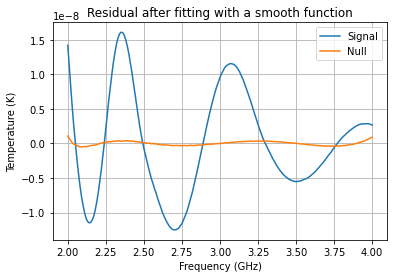

Working for 1d stretch: 0.09 ...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


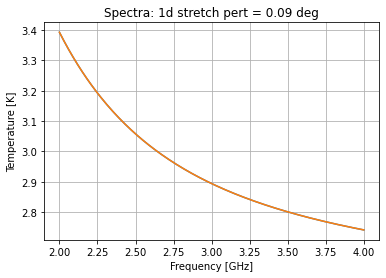

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  1.9707467154991285e-05
2.7266623762864404 -0.14676666404128494 -2.6965743921047363
 
 
chisq2 =  5.933763707620595e-07
2.7256753668911875 -0.14612637690856778 -2.694817272184971 0.028211936146221774
 
 
chisq3 =  8.58245089979484e-09
2.7254165499994603 -0.14597034248369015 -2.693733936388097 0.02945657637737537 0.015071161340289525
 
 
chisq4 =  8.511549110063121e-09
2.7254218092875613 -0.14597354120090852 -2.6937534444194933 0.02938701702369479 0.015022832628850676 -0.00046558455682500105
 
 
chisq5 =  8.48300659135206e-09
2.725423074901739 -0.14597430871769143 -2.6937584355990762 0.029378524537681333 0.014928099680797734 -0.00023510046093550658 -0.0004915258806038199
 
 
chisq6 =  8.446075015378281e-09
2.7254226829055805 -0.145974071010179 -2.6937568958642877 0.029381629661140593 0.014947975024867544 -0.0002304382034268192 -0.0006046407003305872 0.00033476117681912584


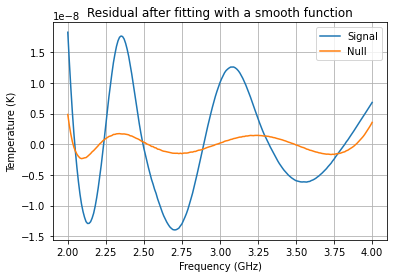

Working for 1d stretch: 0.12 ...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


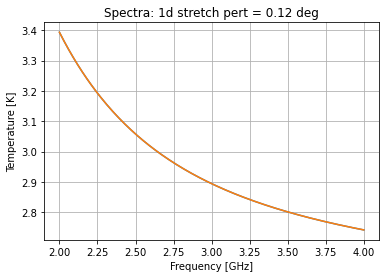

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  2.8494669593999112e-05
2.7270310778735762 -0.14612787506052036 -2.7040985855286905
 
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 272
         Function evaluations: 564
 
chisq2 =  6.548602743971309e-07
2.7256086852514794 -0.14520658551833648 -2.701569997015304 0.04078585867916569
 
 
chisq3 =  3.062478852956305e-08
2.7253217594404955 -0.14503396685373582 -2.7003693966368054 0.04218118994788764 0.016667623760533126
 
 
chisq4 =  8.739550262932377e-09
2.7254627632132333 -0.14511954907724414 -2.700892729290583 0.04031485448613536 0.015356332310654641 -0.0124452665664293
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 640
         Function evaluations: 1187
 
chisq5 =  8.702156792174945e-09
2.725465298131369 -0.145121086397772 -2.700902329600579 0.04028662763906142

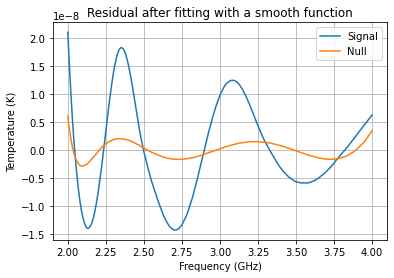

Working for 1d stretch: 0.15 ...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


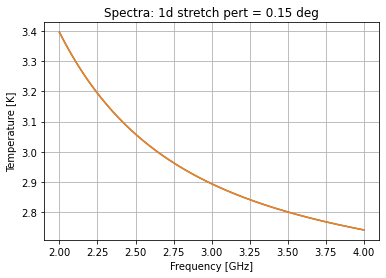

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  4.227011392570586e-05
2.727504417450609 -0.14545361150232067 -2.7129660552670445
 
 
chisq2 =  2.7784277737499516e-07
2.7253986241943142 -0.14409226359609215 -2.7092215890963525 0.060540650971887974
 
 
chisq3 =  6.169683243980865e-08
2.7252788857906918 -0.14402039910469794 -2.7087207701312503 0.061131139479427776 0.006926868909126027
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1097
         Function evaluations: 1944
 
chisq4 =  5.090555945590775e-08
2.7253403907319123 -0.1440576340049468 -2.7089497499673634 0.06032838111054081 0.006256248188524623 -0.0051957016565116615
 
 
chisq5 =  4.858861504558889e-08
2.7253106144829546 -0.14403962671388823 -2.708836486720039 0.06065240290479708 0.007215585873784602 -0.0051958708314012395 0.003452061097593219
 
Optimization terminated successfully.
         Current function

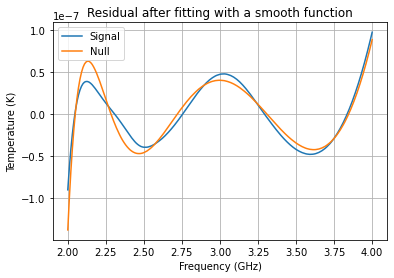

Working for 1d stretch: 0.18 ...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


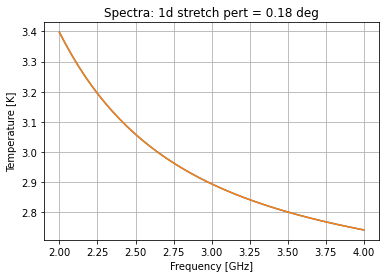

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
Optimization terminated successfully.
         Current function value: 0.000063
         Iterations: 229
         Function evaluations: 464
 
chisq1 =  6.275481078454821e-05
2.7280999174887777 -0.14473675521493817 -2.7234243944777123
 
 
chisq2 =  9.915575529980912e-07
2.7249749304551405 -0.14272127586695255 -2.71785246768934 0.08999134524763314
 
 
chisq3 =  4.8852192315517756e-08
2.725415964460286 -0.14298525951659308 -2.7196968567889668 0.08778490008323028 -0.025389794984813325
 
 
chisq4 =  5.470772566192157e-09
2.725645757548381 -0.14312408604066038 -2.7205517889155355 0.08472749300902528 -0.027511061652383602 -0.02040289039314188
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 462
         Function evaluations: 926
 
chisq5 =  5.46947139289752e-09
2.725645760415839 -0.14312408751192862 -2.720551835031319 0.0847284569756147

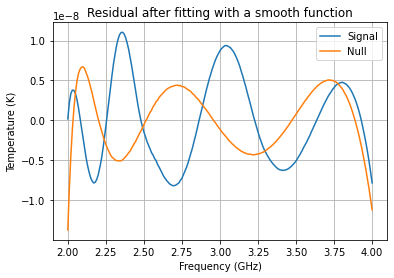

Working for 1d stretch: 0.21 ...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


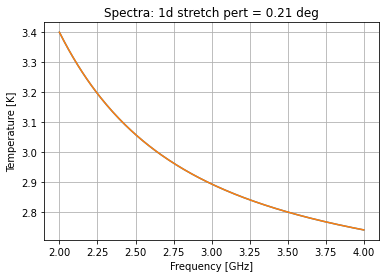

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  9.224431183933419e-05
2.72884007977663 -0.14396855617512475 -2.7357920853036517
 
Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 304
         Function evaluations: 611
 
chisq2 =  3.792067323290209e-06
2.724237810596178 -0.14100914227389838 -2.727534985985071 0.13254500585218565
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 441
         Function evaluations: 839
 
chisq3 =  1.2152394892460816e-07
2.7259318000943433 -0.14202000663459846 -2.734623880944918 0.12397516551552562 -0.09714348892912204
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 733
         Function evaluations: 1315
 
chisq4 =  8.819276359554582e-09
2.7253649625490017 -0.1416785045918736 -2.7325107458608597 0.1315420233663414 -0.09198196048089

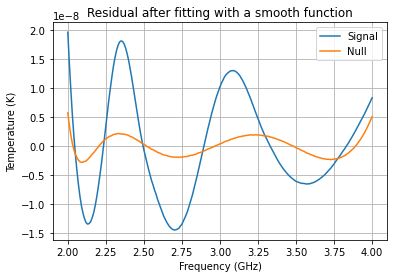

Working for 1d stretch: 0.24 ...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


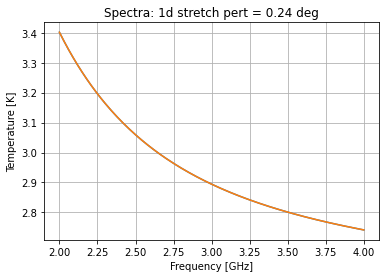

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  0.00013386166491919805
2.729753997132376 -0.14313796964757505 -2.7504837972204452
 
 
chisq2 =  9.148440370962992e-06
2.7230377332946967 -0.1388358065082573 -2.738299072987696 0.19296529890743586
 
 
chisq3 =  1.69837691871244e-06
2.726456196943 -0.14086795462709759 -2.752611553922131 0.1754258616081595 -0.19425069941240525
 
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 857
         Function evaluations: 1520
 
chisq4 =  9.505517463768869e-07
2.72494181262383 -0.13995723705071428 -2.747077240457333 0.1980124802760218 -0.19454607848482913 0.1615667793940659
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 554
         Function evaluations: 1077
 
chisq5 =  2.859721805724901e-07
2.72534808307254 -0.1401988769072111 -2.748781115254185 0.19594377473756897 -0.21780864

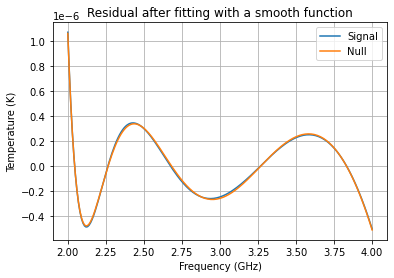

NameError: name 'ED_1d_wobble_with_sig' is not defined

In [10]:
%matplotlib inline

ED_1d_stretch_with_sig = np.zeros(len(np.arange(0.0, 0.25, 0.03)))
ED_1d_stretch_no_sig = np.zeros(len(np.arange(0.0, 0.25, 0.03)))


for pert2 in np.arange(0.0, 0.25, 0.03):
    
    print(f"Working for 1d stretch: {pert2} ...")

    def beam_def(freq, alt, az):
    #     return float(my_interpolating_function([freq, alt, az]))
        if (alt<=0):
            return 0
        else:
            return (math.sin(alt*PI/180)*math.sin(alt*PI/180)) + (freq - 3)*pert2*(math.sin(2*alt*PI/180))*(math.sin(2*alt*PI/180)) 

    i=1
    while i<NPIX:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(16, i , nest = False, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')

        #Now, the coordinates in Galactic frame is changed to equitorial frame below
        equi = gc.transform_to(AltAz(obstime = Time_in_UTC[0], location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg , height=altitude*u.m)))
        alt = equi.alt.value
        new_alt = refraction(alt, altitude) 
        #print(new_alt)

        #Using power law relation to fit spectra of three frequency maps
        def func(xx, a):
            return (sky_408)[i-1] * np.power((xx/0.408), a) 

        xx = np.array([0.408, 1.420, 23])
        yy = np.array([sky_408[i-1], sky_1420[i-1], sky_23000[i-1]])

        popt, pcov = curve_fit(func, xx, yy)



        j=0
        longitudes = equi.az.value
        while j< No_of_Channels:

            cwt = beam_def(freqs[j], new_alt, longitudes)

            if (cwt>=0):     #Adding all the three intensities

                map_1 = (2*k*1e+18 * (freqs[j]**2) *sky_408[i-1]* np.power(freqs[j]/0.408, float(popt)))/ (c**2)


                Power_with_sig = (map_1 + CMB_Int[j] + Rec_int[j]) *(c*c/ (1e+18* freqs[j]**2)) 
                Power_no_sig = (map_1 + CMB_Int[j]) *(c*c/ (1e+18* freqs[j]**2))



                cross_real_with_sig[j] = cross_real_with_sig[j] + cwt*Power_with_sig   
                cross_real_no_sig[j] = cross_real_no_sig[j] + cwt*Power_no_sig


                sumwt_with_sig[j] = sumwt_with_sig[j]+ cwt
                sumwt_no_sig[j] = sumwt_no_sig[j]+ cwt

                final_temp_with_sig[j] = (cross_real_with_sig[j]/P_dif[j])*(T_hot-T_cold)
                final_temp_no_sig[j] = (cross_real_no_sig[j]/P_dif[j])*(T_hot-T_cold)

            j = j+1

        if (i%1000 == 0):
            print('Number of pixels got: ', i)

        i = i+1


    q=0    
    while(q< No_of_Channels):
        if sumwt_with_sig[q]>0 and sumwt_no_sig[q]>0:
            final_temp_with_sig[q] = final_temp_with_sig[q]/sumwt_with_sig[q]
            final_temp_no_sig[q] = final_temp_no_sig[q]/sumwt_no_sig[q]
        q = q+1


    cross_real_with_sig = final_temp_with_sig
    cross_real_no_sig = final_temp_no_sig

    spectra_with_sig = cross_real_with_sig
    spectra_no_sig = cross_real_no_sig

    cross_real_with_sig = [0]*No_of_Channels
    sumwt_with_sig = [0]*No_of_Channels

    cross_real_no_sig = [0]*No_of_Channels
    sumwt_no_sig = [0]*No_of_Channels



    Obs = ephem.Observer()
    t = Time(Time_in_UTC, scale='utc',location=(longitude, latitude))
    lst = t.sidereal_time('apparent')



    plt.plot(freqs, spectra_with_sig, label = "With signal")
    plt.plot(freqs, spectra_no_sig, label = "Null case")
    plt.xlabel('Frequency [GHz]')
    plt.ylabel('Temperature [K]')
    plt.title(f'Spectra: 1d stretch pert = {pert2} deg')
    plt.grid()
    plt.show()



    #______________________________________________________________________________________________________________
    #______________________________________________________________________________________________________________
    #______________________________________________________________________________________________________________

    import numpy as np
    import matplotlib.pyplot as plt
    import scipy.constants
    import random as rndm
    from math import exp, expm1, sqrt
    from math import factorial as mf
    from scipy.optimize import fmin
    from scipy import interpolate
    from matplotlib.backends.backend_pdf import PdfPages

    PI=scipy.constants.pi
    HH=scipy.constants.h
    KK=scipy.constants.k
    HbK=HH/KK
    HbK9=HbK*1.0e9

    X1 = 2.0
    X2 = 4.0
    print (' ')
    print ('CAUTION: this version is hard-coded for freq range: ',X1,' to ',X2,' GHz')

    X1LOG = np.log10(X1)
    X2LOG = np.log10(X2)
    XDIF = X1LOG-X2LOG

    np.set_printoptions(precision=20)



    func1 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                        10.0**( \
                        (p[1]) + \
                        (p[2])*(np.log10(x)-X1LOG)**1 \
                              )

    func2 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                        10.0**( \
                        (p[1]) + \
                        (p[2])*(np.log10(x)-X1LOG)**1 + \
                        (p[3])*(np.log10(x)-X1LOG)**2  \
                              )

    func3 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                        10.0**( \
                        (p[1]) + \
                        (p[2])*(np.log10(x)-X1LOG)**1 + \
                        (p[3])*(np.log10(x)-X1LOG)**2 + \
                        (p[4])*(np.log10(x)-X1LOG)**3  \
                              )

    func4 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                        10.0**( \
                        (p[1]) + \
                        (p[2])*(np.log10(x)-X1LOG)**1 + \
                        (p[3])*(np.log10(x)-X1LOG)**2 + \
                        (p[4])*(np.log10(x)-X1LOG)**3 + \
                        (p[5])*(np.log10(x)-X1LOG)**4  \
                              )

    func5 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                        10.0**( \
                        (p[1]) + \
                        (p[2])*(np.log10(x)-X1LOG)**1 + \
                        (p[3])*(np.log10(x)-X1LOG)**2 + \
                        (p[4])*(np.log10(x)-X1LOG)**3 + \
                        (p[5])*(np.log10(x)-X1LOG)**4 + \
                        (p[6])*(np.log10(x)-X1LOG)**5  \
                              )

    func6 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                        10.0**( \
                        (p[1]) + \
                        (p[2])*(np.log10(x)-X1LOG)**1 + \
                        (p[3])*(np.log10(x)-X1LOG)**2 + \
                        (p[4])*(np.log10(x)-X1LOG)**3 + \
                        (p[5])*(np.log10(x)-X1LOG)**4 + \
                        (p[6])*(np.log10(x)-X1LOG)**5 + \
                        (p[7])*(np.log10(x)-X1LOG)**6  \
                              )

    func7 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                        10.0**( \
                        (p[1]) + \
                        (p[2])*(np.log10(x)-X1LOG)**1 + \
                        (p[3])*(np.log10(x)-X1LOG)**2 + \
                        (p[4])*(np.log10(x)-X1LOG)**3 + \
                        (p[5])*(np.log10(x)-X1LOG)**4 + \
                        (p[6])*(np.log10(x)-X1LOG)**5 + \
                        (p[7])*(np.log10(x)-X1LOG)**6 + \
                        (p[8])*(np.log10(x)-X1LOG)**7  \
                              )
    func8 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                        10.0**( \
                        (p[1]) + \
                        (p[2])*(np.log10(x)-X1LOG)**1 + \
                        (p[3])*(np.log10(x)-X1LOG)**2 + \
                        (p[4])*(np.log10(x)-X1LOG)**3 + \
                        (p[5])*(np.log10(x)-X1LOG)**4 + \
                        (p[6])*(np.log10(x)-X1LOG)**5 + \
                        (p[7])*(np.log10(x)-X1LOG)**6 + \
                        (p[8])*(np.log10(x)-X1LOG)**7 + \
                        (p[9])*(np.log10(x)-X1LOG)**8)

    func9 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                        10.0**( \
                        (p[1]) + \
                        (p[2])*(np.log10(x)-X1LOG)**1 + \
                        (p[3])*(np.log10(x)-X1LOG)**2 + \
                        (p[4])*(np.log10(x)-X1LOG)**3 + \
                        (p[5])*(np.log10(x)-X1LOG)**4 + \
                        (p[6])*(np.log10(x)-X1LOG)**5 + \
                        (p[7])*(np.log10(x)-X1LOG)**6 + \
                        (p[8])*(np.log10(x)-X1LOG)**7 + \
                        (p[9])*(np.log10(x)-X1LOG)**8 + \
                            (p[10])*(np.log10(x)-X1LOG)**9)

    func10 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                        10.0**( \
                        (p[1]) + \
                        (p[2])*(np.log10(x)-X1LOG)**1 + \
                        (p[3])*(np.log10(x)-X1LOG)**2 + \
                        (p[4])*(np.log10(x)-X1LOG)**3 + \
                        (p[5])*(np.log10(x)-X1LOG)**4 + \
                        (p[6])*(np.log10(x)-X1LOG)**5 + \
                        (p[7])*(np.log10(x)-X1LOG)**6 + \
                        (p[8])*(np.log10(x)-X1LOG)**7 + \
                        (p[9])*(np.log10(x)-X1LOG)**8 + \
                            (p[10])*(np.log10(x)-X1LOG)**9+ \
                        (p[11])*(np.log10(x)-X1LOG)**10)	

    func11 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                        10.0**( \
                        (p[1]) + \
                        (p[2])*(np.log10(x)-X1LOG)**1 + \
                        (p[3])*(np.log10(x)-X1LOG)**2 + \
                        (p[4])*(np.log10(x)-X1LOG)**3 + \
                        (p[5])*(np.log10(x)-X1LOG)**4 + \
                        (p[6])*(np.log10(x)-X1LOG)**5 + \
                        (p[7])*(np.log10(x)-X1LOG)**6 + \
                        (p[8])*(np.log10(x)-X1LOG)**7 + \
                        (p[9])*(np.log10(x)-X1LOG)**8 + \
                            (p[10])*(np.log10(x)-X1LOG)**9+ \
                        (p[11])*(np.log10(x)-X1LOG)**10+ \
                        (p[12])*(np.log10(x)-X1LOG)**11)

    func12 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                        10.0**( \
                        (p[1]) + \
                        (p[2])*(np.log10(x)-X1LOG)**1 + \
                        (p[3])*(np.log10(x)-X1LOG)**2 + \
                        (p[4])*(np.log10(x)-X1LOG)**3 + \
                        (p[5])*(np.log10(x)-X1LOG)**4 + \
                        (p[6])*(np.log10(x)-X1LOG)**5 + \
                        (p[7])*(np.log10(x)-X1LOG)**6 + \
                        (p[8])*(np.log10(x)-X1LOG)**7 + \
                        (p[9])*(np.log10(x)-X1LOG)**8 + \
                            (p[10])*(np.log10(x)-X1LOG)**9+ \
                        (p[11])*(np.log10(x)-X1LOG)**10+ \
                        (p[12])*(np.log10(x)-X1LOG)**11+ \
                        (p[13])*(np.log10(x)-X1LOG)**12)	

    # define the function to be minimized by scipy.optimize.fmin
    chisq1 = lambda p, x, y: sqrt(((func1(p,x)-y)**2).sum()/float(len(x)))

    chisq2 = lambda p, x, y: sqrt(((func2(p,x)-y)**2).sum()/float(len(x)))

    def chisq3 (p, x, y):
        k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG)
        for i in range (len(x)-1):
            if k2[i+1]*k2[i] < 0.0: 
                return 100.0+min(i,len(x)-i)
        return sqrt(((func3(p,x)-y)**2).sum()/float(len(x)))

    def chisq4 (p, x, y ):
        k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
            (mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2
        k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG)
        for i in range (len(x)-1):
            if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0: 
                return 100.0+min(i,len(x)-i)
        return sqrt(((func4(p,x)-y)**2).sum()/float(len(x)))

    def chisq5 (p, x, y ):
        k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
            (mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3
        k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
            (mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2
        k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG)
        for i in range (len(x)-1):
            if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0: 
                return 100.0+min(i,len(x)-i)
        return sqrt(((func5(p,x)-y)**2).sum()/float(len(x)))

    def chisq6 (p, x, y ):
        k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
            (mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
            (mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4
        k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
            (mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3
        k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
            (mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2
        k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG)
        for i in range (len(x)-1):
            if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
                or k5[i+1]*k5[i] < 0.0: 
                return 100.0+min(i,len(x)-i)
        return sqrt(((func6(p,x)-y)**2).sum()/float(len(x)))

    def chisq7 (p, x, y):
        k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
            (mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
            (mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4 + (mf(7)/mf(5))*p[8]*(np.log10(x)-X1LOG)**5
        k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
            (mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3 + \
            (mf(7)/mf(4))*p[8]*(np.log10(x)-X1LOG)**4
        k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
            (mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2 + (mf(7)/mf(3))*p[8]*(np.log10(x)-X1LOG)**3
        k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG) + \
            (mf(7)/mf(2))*p[8]*(np.log10(x)-X1LOG)**2
        k6 = (mf(6)/mf(0))*p[7] + (mf(7)/mf(1))*p[8]*(np.log10(x)-X1LOG)
        for i in range (len(x)-1):
            if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
                or k5[i+1]*k5[i] < 0.0 or k6[i+1]*k6[i] < 0.0: 
                return 100.0+min(i,len(x)-i)
        return sqrt(((func7(p,x)-y)**2).sum()/float(len(x)))

    def chisq8 (p, x, y):
        k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
            (mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
            (mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4 + (mf(7)/mf(5))*p[8]*(np.log10(x)-X1LOG)**5 + \
            (mf(8)/mf(6))*p[9]*(np.log10(x)-X1LOG)**6
        k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
            (mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3 + \
            (mf(7)/mf(4))*p[8]*(np.log10(x)-X1LOG)**4 + (mf(8)/mf(5))*p[9]*(np.log10(x)-X1LOG)**5
        k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
            (mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2 + (mf(7)/mf(3))*p[8]*(np.log10(x)-X1LOG)**3 + \
            (mf(8)/mf(4))*p[9]*(np.log10(x)-X1LOG)**4
        k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG) + \
            (mf(7)/mf(2))*p[8]*(np.log10(x)-X1LOG)**2 + (mf(8)/mf(3))*p[9]*(np.log10(x)-X1LOG)**3
        k6 = (mf(6)/mf(0))*p[7] + (mf(7)/mf(1))*p[8]*(np.log10(x)-X1LOG) +  (mf(8)/mf(2))*p[9]*(np.log10(x)-X1LOG)**2
        k7 = (mf(7)/mf(0))*p[8] + (mf(8)/mf(1))*p[9]*(np.log10(x)-X1LOG)
        for i in range (len(x)-1):
            if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
                or k5[i+1]*k5[i] < 0.0 or k6[i+1]*k6[i] < 0.0 or k7[i+1]*k7[i]< 0.0: 
                return 100.0+min(i,len(x)-i)
        return sqrt(((func8(p,x)-y)**2).sum()/float(len(x)))

    def chisq9 (p, x, y):
        k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
            (mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
            (mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4 + (mf(7)/mf(5))*p[8]*(np.log10(x)-X1LOG)**5 + \
            (mf(8)/mf(6))*p[9]*(np.log10(x)-X1LOG)**6 + (mf(9)/mf(7))*p[10]*(np.log10(x)-X1LOG)**7
        k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
            (mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3 + \
            (mf(7)/mf(4))*p[8]*(np.log10(x)-X1LOG)**4 + (mf(8)/mf(5))*p[9]*(np.log10(x)-X1LOG)**5 + \
            (mf(9)/mf(6))*p[10]*(np.log10(x)-X1LOG)**6
        k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
            (mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2 + (mf(7)/mf(3))*p[8]*(np.log10(x)-X1LOG)**3 + \
            (mf(8)/mf(4))*p[9]*(np.log10(x)-X1LOG)**4 + (mf(9)/mf(5))*p[10]*(np.log10(x)-X1LOG)**5
        k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG) + \
            (mf(7)/mf(2))*p[8]*(np.log10(x)-X1LOG)**2 + (mf(8)/mf(3))*p[9]*(np.log10(x)-X1LOG)**3 + \
            (mf(9)/mf(4))*p[10]*(np.log10(x)-X1LOG)**4
        k6 = (mf(6)/mf(0))*p[7] + (mf(7)/mf(1))*p[8]*(np.log10(x)-X1LOG) + (mf(8)/mf(2))*p[9]*(np.log10(x)-X1LOG)**2 + \
               (mf(9)/mf(3))*p[10]*(np.log10(x)-X1LOG)**3
        k7 = (mf(7)/mf(0))*p[8] + (mf(8)/mf(1))*p[9]*(np.log10(x)-X1LOG) + (mf(9)/mf(2))*p[10]*(np.log10(x)-X1LOG)**2
        k8 = (mf(8)/mf(0))*p[9] + (mf(9)/mf(1))*p[10]*(np.log10(x)-X1LOG)
        for i in range (len(x)-1):
            if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
                or k5[i+1]*k5[i] < 0.0 or k6[i+1]*k6[i] < 0.0 or k7[i+1]*k7[i]< 0.0 \
                or k8[i+1]*k8[i]< 0.0: 
                return 100.0+min(i,len(x)-i)
        return sqrt(((func9(p,x)-y)**2).sum()/float(len(x)))

    def chisq10 (p, x, y):
        k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
            (mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
            (mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4 + (mf(7)/mf(5))*p[8]*(np.log10(x)-X1LOG)**5 + \
            (mf(8)/mf(6))*p[9]*(np.log10(x)-X1LOG)**6 + (mf(9)/mf(7))*p[10]*(np.log10(x)-X1LOG)**7 + \
            (mf(10)/mf(8))*p[11]*(np.log10(x)-X1LOG)**8
        k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
            (mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3 + \
            (mf(7)/mf(4))*p[8]*(np.log10(x)-X1LOG)**4 + (mf(8)/mf(5))*p[9]*(np.log10(x)-X1LOG)**5 + \
            (mf(9)/mf(6))*p[10]*(np.log10(x)-X1LOG)**6 + (mf(10)/mf(7))*p[11]*(np.log10(x)-X1LOG)**7
        k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
            (mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2 + (mf(7)/mf(3))*p[8]*(np.log10(x)-X1LOG)**3 + \
            (mf(8)/mf(4))*p[9]*(np.log10(x)-X1LOG)**4 + (mf(9)/mf(5))*p[10]*(np.log10(x)-X1LOG)**5 + \
            (mf(10)/mf(6))*p[11]*(np.log10(x)-X1LOG)**6
        k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG) + \
            (mf(7)/mf(2))*p[8]*(np.log10(x)-X1LOG)**2 + (mf(8)/mf(3))*p[9]*(np.log10(x)-X1LOG)**3 + \
            (mf(9)/mf(4))*p[10]*(np.log10(x)-X1LOG)**4 + (mf(10)/mf(5))*p[11]*(np.log10(x)-X1LOG)**5
        k6 = (mf(6)/mf(0))*p[7] + (mf(7)/mf(1))*p[8]*(np.log10(x)-X1LOG) + (mf(8)/mf(2))*p[9]*(np.log10(x)-X1LOG)**2 + \
               (mf(9)/mf(3))*p[10]*(np.log10(x)-X1LOG)**3 + (mf(10)/mf(4))*p[11]*(np.log10(x)-X1LOG)**4
        k7 = (mf(7)/mf(0))*p[8] + (mf(8)/mf(1))*p[9]*(np.log10(x)-X1LOG) + (mf(9)/mf(2))*p[10]*(np.log10(x)-X1LOG)**2 + \
            (mf(10)/mf(3))*p[11]*(np.log10(x)-X1LOG)**3
        k8 = (mf(8)/mf(0))*p[9] + (mf(9)/mf(1))*p[10]*(np.log10(x)-X1LOG) + (mf(10)/mf(2))*p[11]*(np.log10(x)-X1LOG)**2
        k9 = (mf(9)/mf(0))*p[10] + (mf(10)/mf(1))*p[11]*(np.log10(x)-X1LOG)
        for i in range (len(x)-1):
            if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
                or k5[i+1]*k5[i] < 0.0 or k6[i+1]*k6[i] < 0.0 or k7[i+1]*k7[i]< 0.0 \
                or k8[i+1]*k8[i]< 0.0 or k9[i+1]*k9[i]< 0.0: 
                return 100.0+min(i,len(x)-i)
        return sqrt(((func10(p,x)-y)**2).sum()/float(len(x)))


    residuals = []
    x0 = freqs
    #print(x0)
    x0 = np.asfarray(x0)
    x0log = np.log10(x0)


    low=1.0
    high=5.0


    i_low=0
    i_high=len(x0)
    for i in range(0, len(x0)):
        if x0[i]<=low:
            i_low=i
        if x0[i]<=high:
            i_high=i
    print("Limits in index: ",i_low,i_high)
    x1=x0[i_low:i_high+1]   #Check the +1 term
    x1log = np.log10(x1)
    X1=(x1log[0])
    print(x1.size)

    y1 = np.array(spectra_with_sig)
    print(y1.size)
    y1log = np.log10(y1)



    p12 = np.poly1d(np.polyfit(x1log, y1log, 10))
    yfit_poly = p12(x1log)
    yres_poly = (10.0**yfit_poly) - y1
    #plt.figure()
    #plt.grid()
    #plt.xlabel('Freq [MHz]')
    #plt.ylabel('res Temp [K]')
    #plt.plot(x1*1.0e3,yres_poly,lw=2)
    #plt.plot(np.log10(nu),np.log10(T[pix]),'ro')
    #plt.title('Polyo10 residual spec %s'%(i))
    # plt.show()
    #pdf.savefig()
    #plt.close()
    # Initial guess for optimization				
    p00 = [np.log10(3.0),1.0,-2.5] 

    p1 = fmin(chisq1, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq1, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq1, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
    current_chisq = chisq1(p1,x1,y1)
    print (" ")
    print ("chisq1 = ",current_chisq)
    print (10.0**p1[0], p1[1], p1[2])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],0.0] 
    p1 = fmin(chisq2, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq2, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq2, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
    final_chisq = chisq2(p1,x1,y1)
    print (" ")
    print ("chisq2 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],p1[3],0.0]
    p1 = fmin(chisq3, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq3, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq3, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
    final_chisq = chisq3(p1,x1,y1)
    print (" ")
    print ("chisq3 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],0.0]
    p1 = fmin(chisq4, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq4, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq4, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
    final_chisq = chisq4(p1,x1,y1)
    print (" ")
    print ("chisq4 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],0.0]
    p1 = fmin(chisq5, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq5, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq5, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
    final_chisq = chisq5(p1,x1,y1)
    print (" ")
    print ("chisq5 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],0.0]
    p1 = fmin(chisq6, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq6, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq6, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
    final_chisq = chisq6(p1,x1,y1)
    print (" ")
    print ("chisq6 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],0.0]
    p1 = fmin(chisq7, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq7, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq7, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
    final_chisq = chisq7(p1,x1,y1)
    print (" ")
    print ("chisq7 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],0.0]
    p1 = fmin(chisq8, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
    final_chisq = chisq8(p1,x1,y1)
    print (" ")
    print ("chisq8 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9])

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],p1[9],0.0]
    p1 = fmin(chisq9, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
    final_chisq = chisq9(p1,x1,y1)
    print (" ")
    print ("chisq9 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9],p1[10])

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],p1[9],p1[10],0.0]
    p1 = fmin(chisq10, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
    final_chisq = chisq10(p1,x1,y1)
    print (" ")
    print ("chisq10 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9],p1[10],p1[11])
    print (" ")

    yfit = func10(p1,x1)
    yres = y1 - yfit
    #residuals.append(yres) 
    # scale = 0.03/chisq12(p1,x1,y1)
    # y2 = yfit + scale*(1.0e5**yres)
    yfitlog=np.log10(yfit)

    residuals = np.asfarray(residuals)
    print(residuals)

    sp1_with_sig = y1 -yfit


    #_____________________________________________________________________________________________________________
    #_____________________________________________________________________________________________________________
    #_____________________________________________________________________________________________________________



    residuals = []
    x0 = freqs
    #print(x0)
    x0 = np.asfarray(x0)
    x0log = np.log10(x0)


    low=1.0
    high=5.0


    i_low=0
    i_high=len(x0)
    for i in range(0, len(x0)):
        if x0[i]<=low:
            i_low=i
        if x0[i]<=high:
            i_high=i
    print("Limits in index: ",i_low,i_high)
    x1=x0[i_low:i_high+1]   #Check the +1 term
    x1log = np.log10(x1)
    X1=(x1log[0])
    print(x1.size)

    y1 = np.array(spectra_no_sig)
    print(y1.size)
    y1log = np.log10(y1)



    p12 = np.poly1d(np.polyfit(x1log, y1log, 10))
    yfit_poly = p12(x1log)
    yres_poly = (10.0**yfit_poly) - y1
    #plt.figure()
    #plt.grid()
    #plt.xlabel('Freq [MHz]')
    #plt.ylabel('res Temp [K]')
    #plt.plot(x1*1.0e3,yres_poly,lw=2)
    #plt.plot(np.log10(nu),np.log10(T[pix]),'ro')
    #plt.title('Polyo10 residual spec %s'%(i))
    # plt.show()
    #pdf.savefig()
    #plt.close()
    # Initial guess for optimization				
    p00 = [np.log10(3.0),1.0,-2.5] 

    p1 = fmin(chisq1, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq1, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq1, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
    current_chisq = chisq1(p1,x1,y1)
    print (" ")
    print ("chisq1 = ",current_chisq)
    print (10.0**p1[0], p1[1], p1[2])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],0.0] 
    p1 = fmin(chisq2, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq2, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq2, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
    final_chisq = chisq2(p1,x1,y1)
    print (" ")
    print ("chisq2 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],p1[3],0.0]
    p1 = fmin(chisq3, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq3, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq3, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
    final_chisq = chisq3(p1,x1,y1)
    print (" ")
    print ("chisq3 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],0.0]
    p1 = fmin(chisq4, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq4, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq4, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
    final_chisq = chisq4(p1,x1,y1)
    print (" ")
    print ("chisq4 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],0.0]
    p1 = fmin(chisq5, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq5, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq5, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
    final_chisq = chisq5(p1,x1,y1)
    print (" ")
    print ("chisq5 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],0.0]
    p1 = fmin(chisq6, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq6, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq6, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
    final_chisq = chisq6(p1,x1,y1)
    print (" ")
    print ("chisq6 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],0.0]
    p1 = fmin(chisq7, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq7, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq7, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
    final_chisq = chisq7(p1,x1,y1)
    print (" ")
    print ("chisq7 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],0.0]
    p1 = fmin(chisq8, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
    final_chisq = chisq8(p1,x1,y1)
    print (" ")
    print ("chisq8 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9])

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],p1[9],0.0]
    p1 = fmin(chisq9, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
    final_chisq = chisq9(p1,x1,y1)
    print (" ")
    print ("chisq9 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9],p1[10])

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],p1[9],p1[10],0.0]
    p1 = fmin(chisq10, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
    final_chisq = chisq10(p1,x1,y1)
    print (" ")
    print ("chisq10 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9],p1[10],p1[11])
    print (" ")

    yfit = func10(p1,x1)
    yres = y1 - yfit
    #residuals.append(yres) 
    # scale = 0.03/chisq12(p1,x1,y1)
    # y2 = yfit + scale*(1.0e5**yres)
    yfitlog=np.log10(yfit)

    residuals = np.asfarray(residuals)
    print(residuals)

    sp1_no_sig = y1 -yfit


    np.savetxt(f"Final_Template Bank/Correct_stretch_fn/1d_s_Bangalore_17hlst/Sig_Total_stretch: {round(pert2, 2)}", sp1_with_sig)
    np.savetxt(f"Final_Template Bank/Correct_stretch_fn/1d_s_Bangalore_17hlst/Null_Total_stretch: {round(pert2, 2)}", sp1_no_sig)

    plt.plot(freqs, sp1_with_sig, label = "Signal")
    plt.plot(freqs, sp1_no_sig, label = "Null")
    plt.legend()
    plt.grid()
    plt.ylabel('Temperature (K)')
    plt.xlabel('Frequency (GHz)')
    plt.title('Residual after fitting with a smooth function')
    plt.show()
    
    ED_1d_stretch_with_sig[round(pert2 / 0.03)] = scipy.spatial.distance.euclidean(sp1_with_sig, np.loadtxt("Final_Template Bank/P0_no_noise")) 
    ED_1d_stretch_no_sig[round(pert2 / 0.03)] = scipy.spatial.distance.euclidean(sp1_no_sig, np.loadtxt("Final_Template Bank/P0_no_noise")) 


np.savetxt(f"Final_Template Bank/Correct_stretch_fn/1d_s_Bangalore_17hlst/ED_1d_stretch_with_sig", ED_1d_wobble_with_sig)
np.savetxt(f"Final_Template Bank/Correct_stretch_fn/1d_s_Bangalore_17hlst/ED_1d_stretch_no_sig", ED_1d_wobble_no_sig)


In [11]:
np.savetxt(f"Final_Template Bank/Correct_stretch_fn/1d_s_Bangalore_17hlst/ED_1d_stretch_with_sig", ED_1d_stretch_with_sig)
np.savetxt(f"Final_Template Bank/Correct_stretch_fn/1d_s_Bangalore_17hlst/ED_1d_stretch_no_sig", ED_1d_stretch_no_sig)
